In [1]:
import numpy as np

import matplotlib.pyplot as plt

from crispy.crispy_core import initcoef, transform
from crispy.psf import GaussianPSF

In [2]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['image.origin'] = 'lower'

In [3]:
# IFS simulation parameters

lam_ifs = 660
R=50
nlens=108
pitch=174e-6
interlace=2
slens=0.5
npix=1024
pixsize=13e-6
fwhm=2
npixperdlam=2

In [4]:
# IFS detector image that the psflets will be mapped to 
pad = 10
size = npix + 2 * pad
image = np.zeros((size, size))

In [5]:
# initalize the lenslet coordinates centered at (0,0)
i, j = np.indices((nlens, nlens)) - nlens//2

In [6]:
# wavelength solution calculations
lam = 670
order = 3 
scale = pitch/pixsize
angle = np.arctan(1/interlace)
dispersion = R * npixperdlam * np.log(lam/lam_ifs)
coef = initcoef(order, scale, angle, npix/2 + dispersion, npix/2)

# transform lenslet coord to detector coords of centroids
x, y = transform(i,j,order,coef)

print(x.shape)

(108, 108)


In [7]:
# initalize the psf model
psf_model = GaussianPSF(lam, lam_ifs, fwhm)

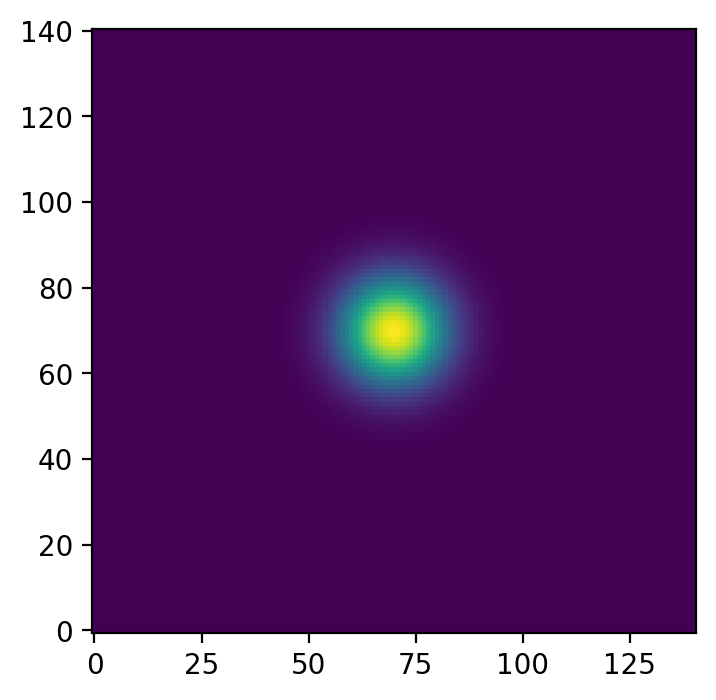

In [8]:
plt.imshow(psf_model._psf)

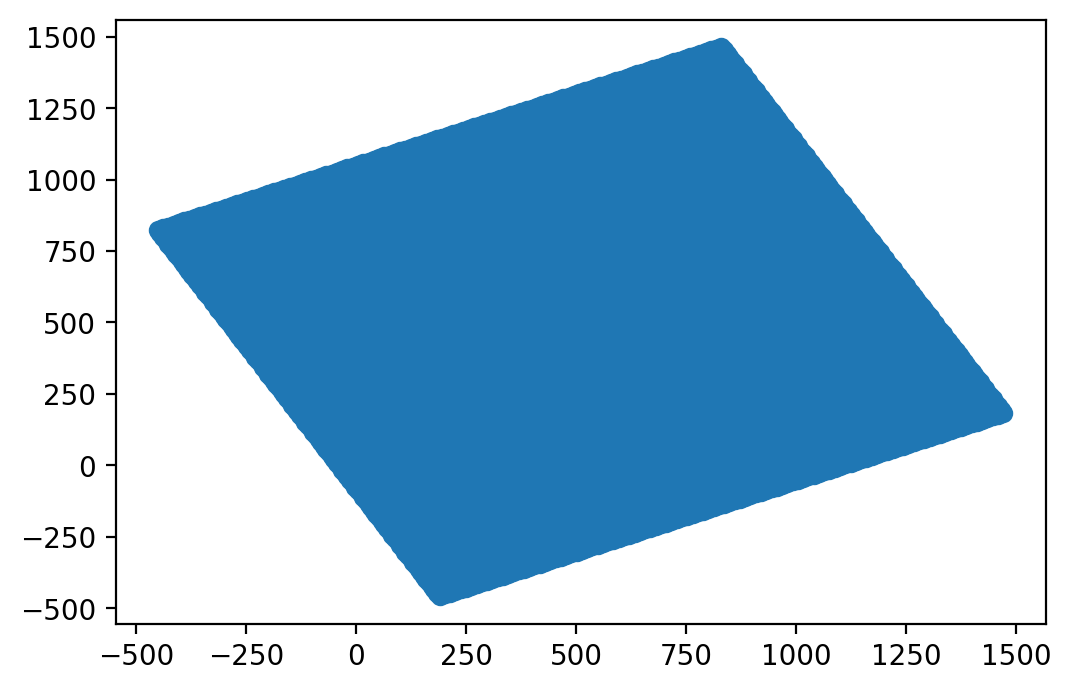

In [9]:
plt.scatter(x,y)
plt.vlines([0, npix], ymin=0, ymax=npix)
plt.hlines([0, npix], xmin=0, xmax=npix)

In [10]:
# update the centroid due to padding
x += pad
y += pad

In [11]:
nsubpix = 13
mask = ((x > nsubpix // 2) & 
        (x < size - nsubpix // 2) & 
        (y > nsubpix // 2) & 
        (y < size - nsubpix // 2))

print(len(mask[mask==1]))
# mask = ((x >= -nsubpix//2) & 
#         (x <= size - nsubpix // 2) & 
#         (y >= nsubpix // 2) & 
#         (y <= size - nsubpix // 2))

5951


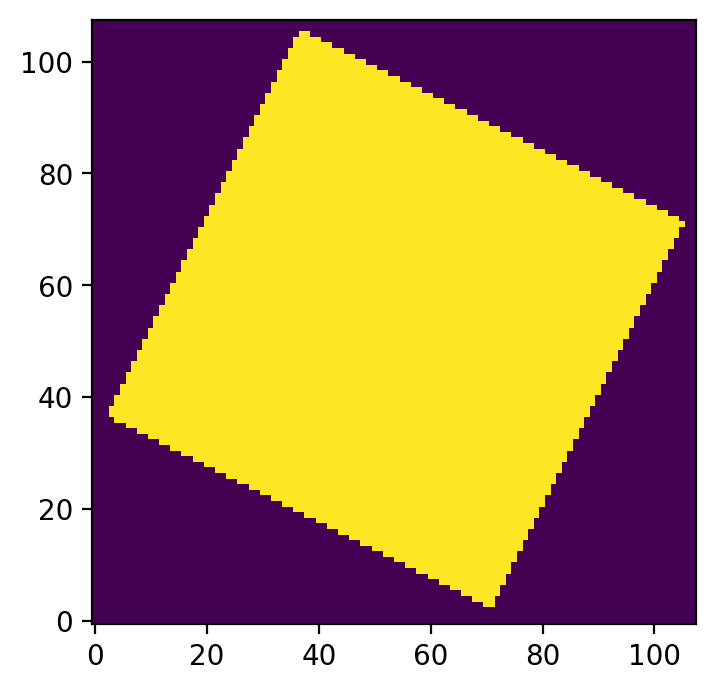

In [12]:
plt.imshow(mask)

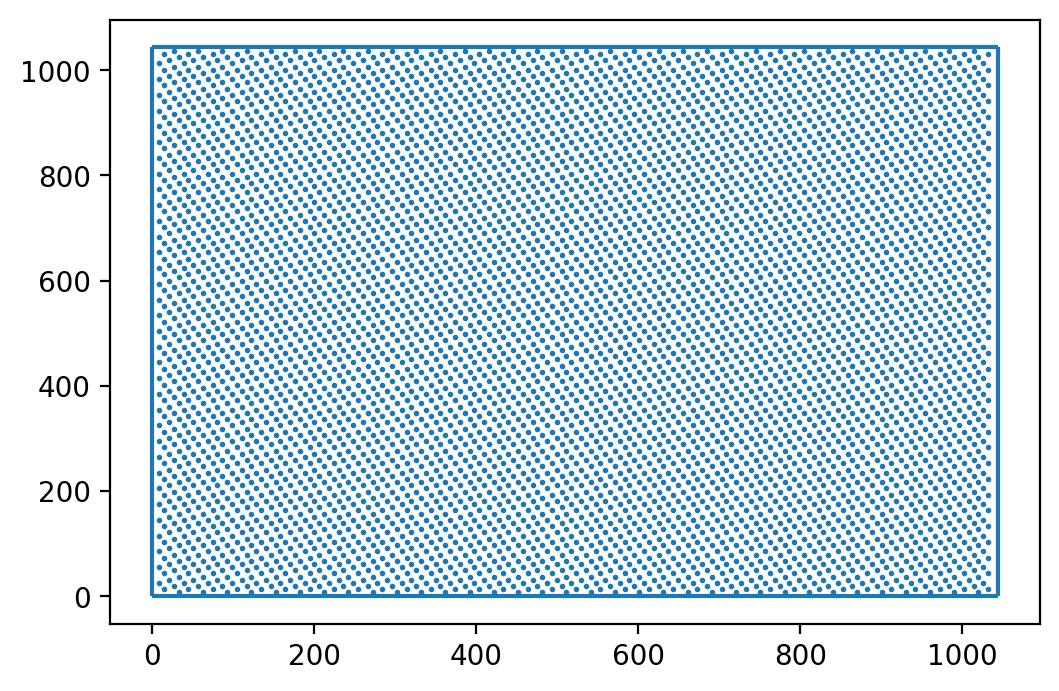

In [13]:
plt.scatter(x[mask],y[mask], s=1)
plt.vlines([0, size], ymin=0, ymax=size)
plt.hlines([0, size], xmin=0, xmax=size)
# plt.vlines([0+pad, size-pad], ymin=0+pad, ymax=size-pad, color='red')
# plt.hlines([0+pad, size-pad], xmin=0+pad, xmax=size-pad, color='red')

In [14]:
temp_y, temp_x = np.indices((nsubpix,nsubpix), dtype=np.int8) - nsubpix//2

In [15]:
temp_y.dtype

dtype('int8')

In [16]:
temp_y

array([[-6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6],
       [-5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5],
       [-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4],
       [-3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3],
       [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
       [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6]], dtype=int8)

In [17]:
x = x[mask].reshape(-1)
y = y[mask].reshape(-1)

dx = x.astype(int) - x
dy = y.astype(int) - y

In [18]:
upsample=10
y_interp = upsample * (temp_y + dy.reshape(-1,1,1) + nsubpix/2)
x_interp = upsample * (temp_x + dx.reshape(-1,1,1) + nsubpix/2)

In [19]:
y_interp = y_interp.astype(np.float32)
x_interp =x_interp.astype(np.float32)

In [20]:
y_interp.dtype

dtype('float32')

In [21]:
y_interp.dtype

dtype('float32')

In [22]:
x_interp.shape

(5951, 13, 13)

In [23]:
psflets = np.array([psf_model.map_psf(coords) for coords in zip(y_interp, x_interp)])

In [26]:
%timeit np.array([psf_model.map_psf(coords) for coords in zip(y_interp, x_interp)])

152 ms ± 4.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%timeit np.array([psf_model.map_psf(coords) for coords in zip(y_interp, x_interp)])

153 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


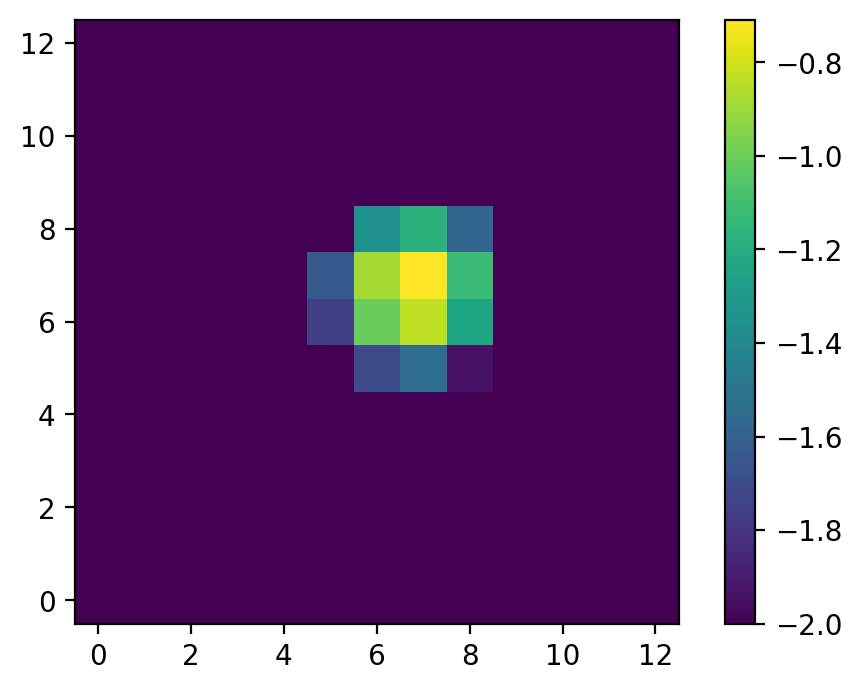

In [34]:
plt.imshow(np.log10(psflets[1]), vmin=-2)
plt.colorbar()

In [35]:
psflets.shape

(5951, 13, 13)

In [36]:
iy1 = y.astype(int) - nsubpix // 2
iy2 = iy1 + nsubpix
ix1 = x.astype(int) - nsubpix // 2
ix2 = ix1 + nsubpix
slices = np.vstack([iy1, iy2, ix1, ix2]).T

In [37]:
for psf, (m, M, n, N) in zip(psflets, slices):
    image[m:M, n:N] += psf
#     try:
#         image[m:M, n:N] += psf
#     except:
#         continue   

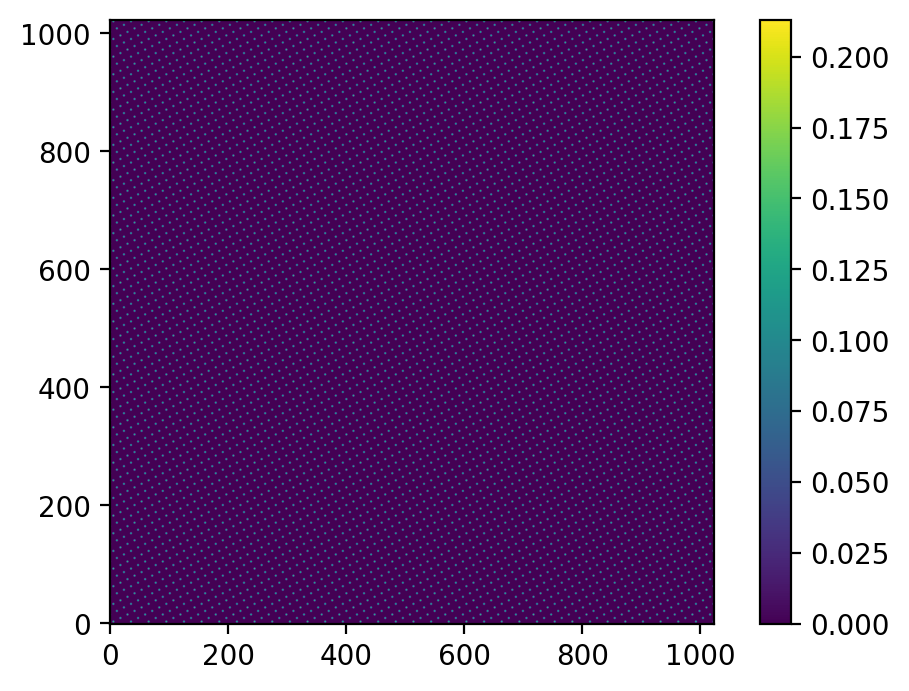

In [38]:
plt.imshow(image[pad:-pad, pad:-pad])
plt.colorbar()

In [39]:
# next week convert the above into a function with input for wavelength to produce and monochromatic image.

In [2]:
np.indices((nsubpix,nsubpix))

NameError: name 'np' is not defined

In [279]:
def propagate_lenslets(wavelength, vector=True, map_order=3):
    pad = 10
    size = npix + 2 * pad
    image = np.zeros((size, size))
    
    ####
    psf_model = GaussianPSF(lam, lam_ifs, fwhm)
    psf_data = psf_model._psf
    psf_data = psf_data.reshape(1, *psf_data.shape)
    
    order = 3 
    scale = pitch/pixsize
    angle = np.arctan(1/interlace)
    dispersion = R * npixperdlam * np.log(wavelength/lam_ifs)
    coef = initcoef(order, scale, angle, npix/2 + dispersion, npix/2)

    # transform lenslet coord to detector coords of centroids
    x, y = transform(i,j,order,coef)
    x += pad
    y += pad
    
    mask = ((x > nsubpix // 2) & 
        (x < size - nsubpix // 2) & 
        (y > nsubpix // 2) & 
        (y < size - nsubpix // 2))
    
    temp_y, temp_x = np.indices((nsubpix,nsubpix), dtype=np.float64) - nsubpix//2
    
    x = x[mask].reshape(-1)
    y = y[mask].reshape(-1)

    dx = x.astype(int) - x
    dy = y.astype(int) - y

    y_interp = upsample * (temp_y + dy.reshape(-1,1,1) + nsubpix/2)
    x_interp = upsample * (temp_x + dx.reshape(-1,1,1) + nsubpix/2)
    
#     psflets = np.array([psf_model.map_psf(coords) for coords in zip(y_interp, x_interp)])
#     psflets = np.array(list(map(psf_model.map_psf, zip(y_interp, x_interp))))
#     psflets = np.vectorize(psf_model.map_psf, signature='(n),(m)->()')([y_interp, x_interp])
    if vector:
        # needs the coords of the npsf which in this case is zero
        test_coords = np.broadcast_arrays(np.arange(y_interp.shape[0])[:, None, None]*0, y_interp, x_interp)
        psflets = map_coordinates(psf_data, test_coords, order=map_order, prefilter=False)
    else:
        psflets = np.array([psf_model.map_psf(coords) for coords in zip(y_interp, x_interp)])
    
    print(psflets[0].sum(), psf_data.dtype)
#     print(np.allclose(psflets.sum((1,2)), np.ones(len(psflets))))
    
    iy1 = y.astype(int) - nsubpix // 2
    iy2 = iy1 + nsubpix
    ix1 = x.astype(int) - nsubpix // 2
    ix2 = ix1 + nsubpix
    slices = np.vstack([iy1, iy2, ix1, ix2]).T
#     slices = np.vstack([iy1, ix1]).T
    
#     for psf, (m, n) in zip(psflets, slices):
#         image[m:m+nsubpix, n:n+nsubpix] += psf
    
    for psf, (m, M, n, N) in zip(psflets, slices):
        image[m:M, n:N] += psf
        
#     for psf, (m, M, n, N) in zip(psflets, slices):
#         image[m:M, n:N] += psf
        
#     for p, psf in enumerate(psflets):
#         m, n = int(x[p])-nsubpix // 2, int(y[p])-nsubpix // 2
#         image[m:m+nsubpix, n:n+nsubpix] += psf
#         np.add.at(image,np.ogrid[n:N, m:M], psf)
        
    return image

In [336]:
def propagate_lenslets(wavelength, vector=True, map_order=3):
    pad = 10
    size = npix + 2 * pad
    image = np.zeros((size, size))
    
    ####
    psf_model = GaussianPSF(lam, lam_ifs, fwhm)
    psf_data = psf_model._psf
#     psf_data = psf_data.reshape(1, *psf_data.shape)
    
    order = 3 
    scale = pitch/pixsize
    angle = np.arctan(1/interlace)
    dispersion = R * npixperdlam * np.log(wavelength/lam_ifs)
    coef = initcoef(order, scale, angle, npix/2 + dispersion, npix/2)

    # transform lenslet coord to detector coords of centroids
    x, y = transform(i,j,order,coef)
    x += pad
    y += pad
    
    mask = ((x > nsubpix // 2) & 
        (x < size - nsubpix // 2) & 
        (y > nsubpix // 2) & 
        (y < size - nsubpix // 2))
    
    temp_y, temp_x = np.indices((nsubpix,nsubpix), dtype=np.float64) - nsubpix//2
    
    x = x[mask].reshape(-1)
    y = y[mask].reshape(-1)

    dx = x.astype(int) - x
    dy = y.astype(int) - y

    y_interp = upsample * (temp_y + dy.reshape(-1,1,1) + nsubpix/2)
    x_interp = upsample * (temp_x + dx.reshape(-1,1,1) + nsubpix/2)
    
#     psflets = np.array([psf_model.map_psf(coords) for coords in zip(y_interp, x_interp)])
#     psflets = np.array(list(map(psf_model.map_psf, zip(y_interp, x_interp))))
#     psflets = np.vectorize(psf_model.map_psf, signature='(n),(m)->()')([y_interp, x_interp])
    iy1 = y.astype(int) - nsubpix // 2
    iy2 = iy1 + nsubpix
    ix1 = x.astype(int) - nsubpix // 2
    ix2 = ix1 + nsubpix
    slices = np.vstack([iy1, iy2, ix1, ix2]).T
    
    
    
    for (m, M, n, N), y,x in zip(slices, y_interp, x_interp):
        map_coordinates(psf_data, 
                        [y,x], 
                        output=image[m:M, n:N],
                        order=map_order, 
                        prefilter=False)
        
    
    
    
    
    
#     if vector:
#         # needs the coords of the npsf which in this case is zero
#         test_coords = np.broadcast_arrays(np.arange(y_interp.shape[0])[:, None, None]*0, y_interp, x_interp)
#         psflets = map_coordinates(psf_data, 
#                                   test_coords,
#                                   order=map_order,
#                                   prefilter=False)
# #         map_coordinates(psf_data, 
# #                         test_coords,
# #                         output = [image[m:M, n:N] for (m, M, n, N) in slices],
# #                         order=map_order,
# #                         prefilter=False)
#     else:
#         psflets = np.array([psf_model.map_psf(coords) for coords in zip(y_interp, x_interp)])
#         map_coordinates(psf_data, test_coords, order=map_order, prefilter=False)
    
#     print(psflets[0].sum(), psf_data.dtype)
#     print(np.allclose(psflets.sum((1,2)), np.ones(len(psflets))))
    
    
#     slices = np.vstack([iy1, ix1]).T
    
#     for psf, (m, n) in zip(psflets, slices):
#         image[m:m+nsubpix, n:n+nsubpix] += psf
    
#     for psf, (m, M, n, N) in zip(psflets, slices):
#         image[m:M, n:N] += psf
        
#     for psf, (m, M, n, N) in zip(psflets, slices):
#         image[m:M, n:N] += psf
        
#     for p, psf in enumerate(psflets):
#         m, n = int(x[p])-nsubpix // 2, int(y[p])-nsubpix // 2
#         image[m:m+nsubpix, n:n+nsubpix] += psf
#         np.add.at(image,np.ogrid[n:N, m:M], psf)
        
    return image

In [337]:
test_1 = propagate_lenslets(wavelengths[0], vector=False)
test_2 = propagate_lenslets(wavelengths[0], map_order=3)

In [338]:
import time

t1 = time.time()
propagate_lenslets(wavelengths[0], vector=True, map_order=3)
t2 = time.time()
print(t2-t1)

0.1399984359741211


In [339]:
test_1.sum()/test_2.sum()

1.0

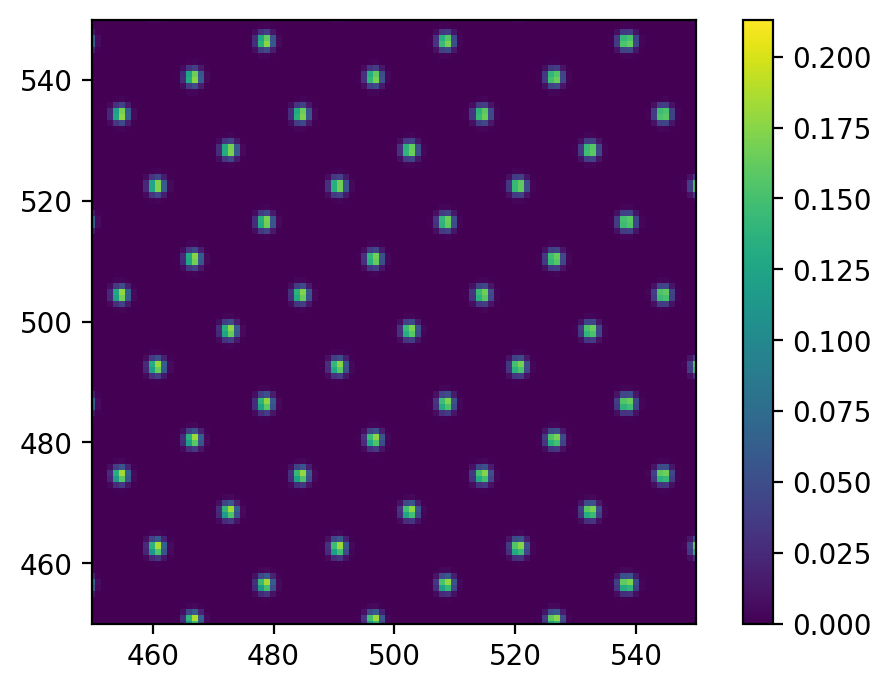

In [340]:
plt.imshow(test_2)
plt.axis([450,550, 450,550])
plt.colorbar()

In [217]:
%timeit propagate_lenslets(wavelengths[0])

125 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [92]:
np.eye(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [84]:
np.mgrid[5:18, 3:16].shape

(2, 13, 13)

In [342]:
wavelengths = np.linspace(650-2.5, 750+2.5, 10)

images = list(map(propagate_lenslets, wavelengths))

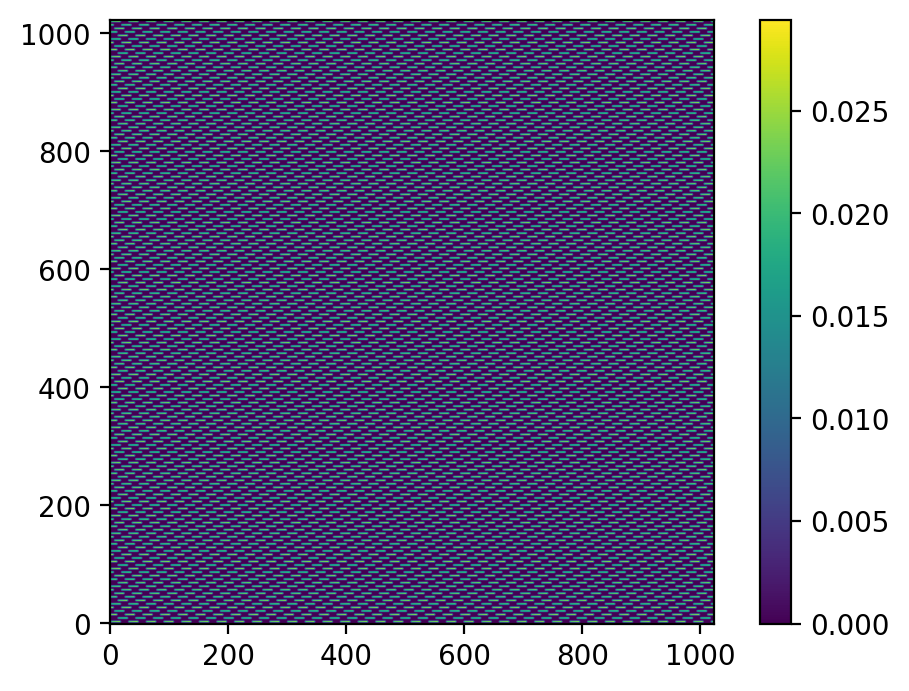

In [343]:
plt.imshow(sum(images)[pad:-pad, pad:-pad]/len(wavelengths))
plt.colorbar()

In [344]:
%timeit list(map(propagate_lenslets, wavelengths))

1.46 s ± 46.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [213]:
%timeit list(map(propagate_lenslets, wavelengths))

1.23 s ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [345]:
%timeit [propagate_lenslets(wlen) for wlen in wavelengths]

1.42 s ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%load_ext line_profiler

In [341]:
%lprun -s -f propagate_lenslets -T lp_results.txt propagate_lenslets(wavelengths[0], vector=False)


*** Profile printout saved to text file 'lp_results.txt'. 


Timer unit: 1e-07 s

Total time: 0.226064 s
File: <ipython-input-336-ffeacaf4eba0>
Function: propagate_lenslets at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def propagate_lenslets(wavelength, vector=True, map_order=3):
     2         1        107.0    107.0      0.0      pad = 10
     3         1         13.0     13.0      0.0      size = npix + 2 * pad
     4         1        218.0    218.0      0.0      image = np.zeros((size, size))
     5                                               
     6                                               ####
     7         1      26382.0  26382.0      1.2      psf_model = GaussianPSF(lam, lam_ifs, fwhm)
     8         1         11.0     11.0      0.0      psf_data = psf_model._psf
     9                                           #     psf_data = psf_data.reshape(1, *psf_data.shape)
    10                                               
    11         1          5.0      5.

In [262]:
%lprun -s -f propagate_lenslets -T lp_results.txt propagate_lenslets(wavelengths[0], vector=True)

0.999999199923926 float64

*** Profile printout saved to text file 'lp_results.txt'. 


Timer unit: 1e-07 s

Total time: 0.421776 s
File: <ipython-input-254-91ec0acde2ed>
Function: propagate_lenslets at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def propagate_lenslets(wavelength, vector=True, map_order=3):
     2         1         15.0     15.0      0.0      pad = 10
     3         1         10.0     10.0      0.0      size = npix + 2 * pad
     4         1       1045.0   1045.0      0.0      image = np.zeros((size, size))
     5                                               
     6                                               ####
     7         1      25776.0  25776.0      0.6      psf_model = GaussianPSF(lam, lam_ifs, fwhm)
     8         1         14.0     14.0      0.0      psf_data = psf_model._psf
     9         1         30.0     30.0      0.0      psf_data = psf_data.reshape(1, *psf_data.shape)
    10                                               
    11         1          5.0      5.0 

In [76]:
%lprun -s -f propagate_lenslets -T lp_results.txt propagate_lenslets(wavelengths[0])

<ipython-input-71-e0a755033e3c>:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  np.add.at(image,[*np.mgrid[n:N, m:M]], psf)



*** Profile printout saved to text file 'lp_results.txt'. 


Timer unit: 1e-07 s

Total time: 0.601919 s
File: <ipython-input-71-e0a755033e3c>
Function: propagate_lenslets at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def propagate_lenslets(wavelength):
     2         1         19.0     19.0      0.0      pad = 10
     3         1         16.0     16.0      0.0      size = npix + 2 * pad
     4         1        256.0    256.0      0.0      image = np.zeros((size, size))
     5                                               
     6                                               ####
     7         1      28168.0  28168.0      0.5      psf_model = GaussianPSF(lam, lam_ifs, fwhm)
     8                                               
     9                                               ###
    10         1         10.0     10.0      0.0      order = 3 
    11         1         12.0     12.0      0.0      scale = pitch/pixsize
    12         1         30.0     30.0      0.0   

In [53]:
%lprun -s -f propagate_lenslets -T lp_results.txt propagate_lenslets(wavelengths[0])


*** Profile printout saved to text file 'lp_results.txt'. 


Timer unit: 1e-07 s

Total time: 0.27312 s
File: <ipython-input-52-8bad8efde8eb>
Function: propagate_lenslets at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def propagate_lenslets(wavelength):
     2         1         13.0     13.0      0.0      pad = 10
     3         1         14.0     14.0      0.0      size = npix + 2 * pad
     4         1        216.0    216.0      0.0      image = np.zeros((size, size))
     5                                               
     6                                               ####
     7         1      23304.0  23304.0      0.9      psf_model = GaussianPSF(lam, lam_ifs, fwhm)
     8                                               
     9                                               ###
    10         1         11.0     11.0      0.0      order = 3 
    11         1         10.0     10.0      0.0      scale = pitch/pixsize
    12         1         29.0     29.0      0.0    

In [95]:
import numpy as np
from scipy.ndimage import map_coordinates
m = np.array([
    [10,10,10,10,10,10],
    [9,9,9,10,9,9],
    [9,8,9,10,8,9],
    [9,7,8,0,8,9],
    [8,7,7,8,8,9],
    [5,6,7,7,6,7]])

origin_row = 3
origin_col = 3
rows, cols = m.shape

num = 5
lin_col = np.array([np.linspace(i, origin_col, num) for i in range(cols)])
lin_row = np.array([np.linspace(i, origin_row, num) for i in range(rows)])

arr_vs = np.vstack(( np.tile( lin_row, cols).ravel(),
                     np.tile( lin_col.ravel(), rows)))

arr_map = map_coordinates(m, arr_vs, order=1, mode='nearest').reshape(rows,cols,num)
m_max = np.max( arr_map, axis=-1)
m_dist = np.argmax( arr_map, axis=-1)

print (m_max)
print (m_dist)

[[10 10 10 10 10 10]
 [ 9  9 10 10  9  9]
 [ 9  9  9 10  8  9]
 [ 9  8  8  0  8  9]
 [ 8  8  7  8  8  9]
 [ 7  7  8  8  8  8]]
[[0 0 0 0 0 0]
 [0 0 2 0 0 0]
 [0 2 0 0 0 0]
 [0 1 0 0 0 0]
 [0 2 0 0 0 0]
 [1 1 2 1 2 1]]


In [107]:
n, x, y = np.meshgrid(range(4), range(13), range(13))

In [110]:
n[1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])

In [ ]:
psf

In [101]:
lin_row

array([[0.  , 0.75, 1.5 , 2.25, 3.  ],
       [1.  , 1.5 , 2.  , 2.5 , 3.  ],
       [2.  , 2.25, 2.5 , 2.75, 3.  ],
       [3.  , 3.  , 3.  , 3.  , 3.  ],
       [4.  , 3.75, 3.5 , 3.25, 3.  ],
       [5.  , 4.5 , 4.  , 3.5 , 3.  ]])

In [102]:
lin_col

array([[0.  , 0.75, 1.5 , 2.25, 3.  ],
       [1.  , 1.5 , 2.  , 2.5 , 3.  ],
       [2.  , 2.25, 2.5 , 2.75, 3.  ],
       [3.  , 3.  , 3.  , 3.  , 3.  ],
       [4.  , 3.75, 3.5 , 3.25, 3.  ],
       [5.  , 4.5 , 4.  , 3.5 , 3.  ]])

In [179]:
#arr_vs.T

In [98]:
m

array([[10, 10, 10, 10, 10, 10],
       [ 9,  9,  9, 10,  9,  9],
       [ 9,  8,  9, 10,  8,  9],
       [ 9,  7,  8,  0,  8,  9],
       [ 8,  7,  7,  8,  8,  9],
       [ 5,  6,  7,  7,  6,  7]])

In [114]:
from scipy import ndimage
# https://stackoverflow.com/questions/20338663/efficiently-sample-all-arrays-in-ndarray-using-scipy-ndimage-map-coordinates
a = np.random.rand(1461, 390, 327)

x = np.array([ 117.38670304,  119.1220485 ])

y = np.array([ 209.98120554,  210.37202372])

In [115]:
map_coord = np.array([[y,], [x,]])

In [117]:
np.shape(map_coord)

(2, 1, 2)

In [116]:
%timeit np.concatenate([ndimage.map_coordinates(ai, map_coord, order=1) for ai in a])
# 10 loops, best of 3: 33.1 ms per loop

13 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [121]:
map_coords = np.broadcast_arrays(np.arange(a.shape[0])[:, None], y, x)
print(np.shape(map_coords))

(3, 1461, 2)


In [122]:
%timeit ndimage.map_coordinates(a, map_coords, order=1)
#100 loops, best of 3: 4.67 ms per loop

279 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [123]:
samp_OP = np.concatenate([ndimage.map_coordinates(ai, map_coord, order=1) for ai in a])

samp_chan = ndimage.map_coordinates(a, map_coords, order=1)

np.allclose(samp_chan, samp_OP)
# True

True

In [124]:
samp_OP

array([[0.35774846, 0.39273925],
       [0.25546542, 0.68680767],
       [0.52263978, 0.50658917],
       ...,
       [0.65527141, 0.42167933],
       [0.2781288 , 0.55095478],
       [0.39794715, 0.48067608]])

In [125]:
samp_chan

array([[0.35774846, 0.39273925],
       [0.25546542, 0.68680767],
       [0.52263978, 0.50658917],
       ...,
       [0.65527141, 0.42167933],
       [0.2781288 , 0.55095478],
       [0.39794715, 0.48067608]])

In [128]:
a.shape, np.array(map_coords).shape

((1461, 390, 327), (3, 1461, 2))

In [129]:
samp_OP.shape

(1461, 2)

In [130]:
np.broadcast_arrays(np.arange(a.shape[0])[:, None], y, x)

[array([[   0,    0],
        [   1,    1],
        [   2,    2],
        ...,
        [1458, 1458],
        [1459, 1459],
        [1460, 1460]]),
 array([[209.98120554, 210.37202372],
        [209.98120554, 210.37202372],
        [209.98120554, 210.37202372],
        ...,
        [209.98120554, 210.37202372],
        [209.98120554, 210.37202372],
        [209.98120554, 210.37202372]]),
 array([[117.38670304, 119.1220485 ],
        [117.38670304, 119.1220485 ],
        [117.38670304, 119.1220485 ],
        ...,
        [117.38670304, 119.1220485 ],
        [117.38670304, 119.1220485 ],
        [117.38670304, 119.1220485 ]])]

In [131]:
from scipy import ndimage
a = np.arange(100).reshape((10, 10))
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [136]:
coords = np.meshgrid(np.linspace(0.5, 2, 13), (np.linspace(0.5, 1, 13)))
ndimage.map_coordinates(a, coords, order=1)
# ndimage.map_coordinates(a, [[0.5, 2], [0.5, 1]], order=1)
# array([ 2.,  7.])

array([[ 6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21],
       [ 6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21],
       [ 6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21],
       [ 6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21],
       [ 6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21],
       [ 6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21],
       [ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21],
       [ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21],
       [ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21],
       [ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21],
       [ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21],
       [ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21],
       [ 6,  7,  9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21]])

In [142]:
test_coords = np.broadcast_arrays(np.arange(1)[:, None], coords[0], coords[1])

In [148]:
test_coords 

[array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125, 1.25 , 1.375, 1.5  ,
         1.625, 1.75 , 1.875, 2.   ],
        [0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125, 1.25 , 1.375, 1.5  ,
         1.625, 1.75 , 1.875, 2.   ],
        [0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125, 1.25 , 1.375, 1.5  ,
         1.625, 1.75 , 1.875, 2.   ],
        [0.5  , 0.625, 0.75 , 0

In [145]:
ndimage.map_coordinates(a.reshape(1,*a.shape), test_coords, order=1)

array([[ 6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21],
       [ 6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21],
       [ 6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21],
       [ 6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21],
       [ 6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21],
       [ 6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21],
       [ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21],
       [ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21],
       [ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21],
       [ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21],
       [ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21],
       [ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21],
       [ 6,  7,  9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21]])

In [151]:
np.broadcast_arrays(np.arange(100)[:, None], y_interp, x_interp)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [153]:
np.shape(test_coords)

(3, 13, 13)

In [152]:
y_interp.shape

(5951, 13, 13)

In [155]:
input_map = psf_model._psf

In [157]:
input_map_nd = np.tile(input_map, (y_interp.shape[0], 1,1))
input_map_nd.shape

(5951, 141, 141)

In [168]:
input_map_nd = input_map.reshape(1, *input_map.shape)

In [298]:
test_coords = np.broadcast_arrays(np.arange(y_interp.shape[0])[:, None, None]*0, y_interp, x_interp)
# test_coords = [np.zeros(y_interp.shape[0]), y_interp, x_interp]

In [299]:
list(map(np.shape, test_coords))#test_coords

[(5951, 13, 13), (5951, 13, 13), (5951, 13, 13)]

In [302]:
test_res = map_coordinates(input_map_nd, test_coords, prefilter=True)

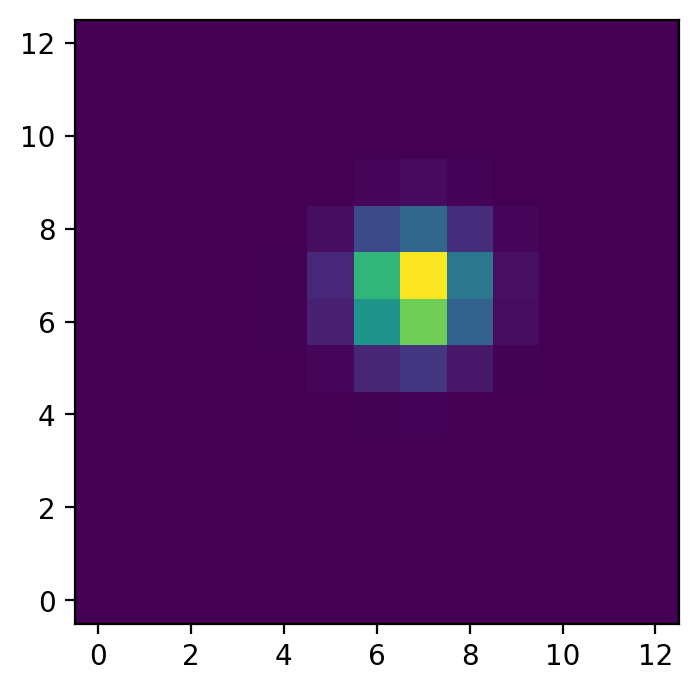

In [303]:
plt.imshow(test_res[5])

In [163]:
%timeit map_coordinates(input_map_nd, test_coords, prefilter=False)

263 ms ± 8.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [304]:
from scipy.ndimage._nd_image import geometric_transform

In [ ]:
def map_coordiantes_new(input, coords, order, output=None)

    if order < 0 or order > 5:
        raise RuntimeError('spline order not supported')
    input = numpy.asarray(input)
    coordinates = numpy.asarray(coordinates)
    if numpy.iscomplexobj(coordinates):
        raise TypeError('Complex type not supported')
    output_shape = coordinates.shape[1:]
    if input.ndim < 1 or len(output_shape) < 1:
        raise RuntimeError('input and output rank must be > 0')
    if coordinates.shape[0] != input.ndim:
        raise RuntimeError('invalid shape for coordinate array')
    complex_output = numpy.iscomplexobj(input)
    output = _ni_support._get_output(output, input, shape=output_shape,
                                     complex_output=complex_output)
    if complex_output:
        kwargs = dict(order=order, mode=mode, prefilter=prefilter)
        map_coordinates(input.real, coordinates, output=output.real,
                        cval=numpy.real(cval), **kwargs)
        map_coordinates(input.imag, coordinates, output=output.imag,
                        cval=numpy.imag(cval), **kwargs)
        return output
    if prefilter and order > 1:
        padded, npad = _prepad_for_spline_filter(input, mode, cval)
        filtered = spline_filter(padded, order, output=numpy.float64,
                                 mode=mode)
    else:
        npad = 0
        filtered = input
    mode = _ni_support._extend_mode_to_code(mode)
    _nd_image.geometric_transform(filtered, None, coordinates, None, None,
                                  output, order, mode, cval, npad, None, None)
    return output